In [1]:
import numpy as np
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers


In [3]:

from autoencoder.model import Sampling

In [7]:
encoder = keras.models.load_model('trained_models/vae_encoder_epoch_24.h5',
                                  custom_objects={'Sampling': Sampling,})

decoder = keras.models.load_model('trained_models/vae_decoder_epoch_24.h5')

In [8]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              135168    
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 16)       9232      
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 32)       4640      
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 64)       1849

In [10]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   1216        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 32)   4640        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d_1[0][0]']               
                                                                                            

In [11]:
import h5py
import jax

In [12]:
rng = jax.random.PRNGKey(0)

In [13]:
with h5py.File("/Users/henningse/Downloads/Galaxy10.h5", 'r') as F:
  labels = np.array(F['ans'])
  # reject some we don't care about, keep the rest
  (milkywaylikes_idx,) = np.where(labels > 3)
  images = np.array(F['images'][milkywaylikes_idx])
  # Milky way similar galaxies are class '3' ('-4' normalizes the labels again)
  labels = np.array(F['ans'][milkywaylikes_idx]) - 4

images = images.astype(np.float32) / 255.

# crop the image a bit to get 64x64 shape
def crop_center(images, cropx, cropy):
    _, y, x, _ = images.shape
    startx = x // 2 -(cropx // 2)
    starty = y // 2 -(cropy // 2)    
    return images[:, starty:starty+cropy, startx:startx+cropx, :]

images = crop_center(images=images, cropx=64, cropy=64)

# shuffle once
rng, key = jax.random.split(rng)
shuffle_idx = jax.random.randint(key, (len(images),), 0, len(images))
images = images[shuffle_idx, ...]
labels = labels[shuffle_idx, ...]

In [14]:
ll = encoder.predict(images)

 16/147 [==>...........................] - ETA: 0s 

2022-11-30 21:33:52.221640: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


147/147 [==============================] - 1s 3ms/step


In [15]:
ri = decoder.predict(ll[0])

147/147 [==============================] - 1s 7ms/step


In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt


In [17]:
def show_galaxies(images: np.ndarray) -> None:
  n = len(images)
  # always 4 in a column
  ncols = 4
  nrows = -(-n // ncols)
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12))

  for img, ax in zip(images, axes.ravel()):
    ax.imshow(img)
    ax.axis('off')
    fig.tight_layout()

# plot first 8 images


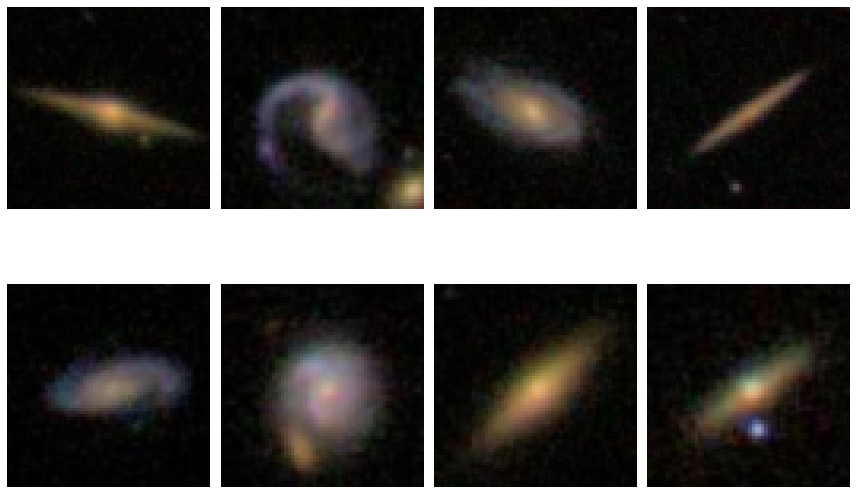

In [18]:
show_galaxies(images[:8])

In [19]:
img_index = np.random.choice(np.arange(len(ri)),size = 8)

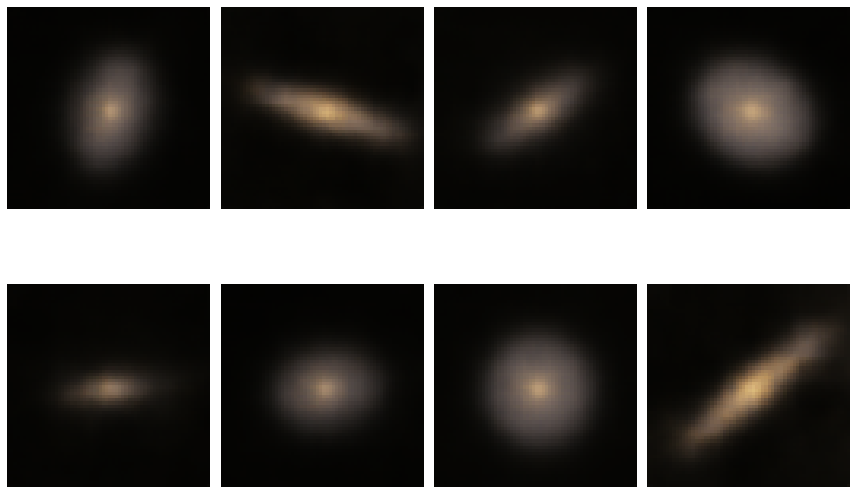

In [21]:
show_galaxies(ri[img_index])

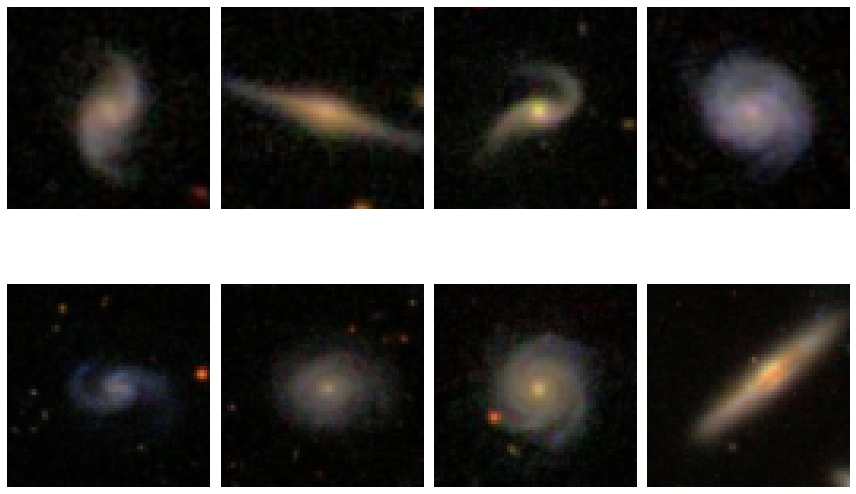

In [22]:
show_galaxies(images[img_index])